In [3]:
import matplotlib.pyplot as plt
from custom_scalar_formatter import CustomScalarFormatter
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import os

In [4]:
# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
def load_results_opt(results_dir, dataset, opt, n_runs):
    results = {}

    optimizer = opt['optimizer']
    if 'precond' in list(opt.keys()):
        preconditioner = opt['precond']
        results_dir = os.path.join(results_dir, dataset, optimizer, preconditioner)
    else:
        results_dir = os.path.join(results_dir, dataset, optimizer)

    for i in range(1, n_runs+1):
        results_dir_run = os.path.join(results_dir, 'run_' + str(i))
        filenames = os.listdir(results_dir_run)        
        
        if optimizer in ['adasgd','sketchysgd']:
            for filename in filenames:
                if filename.endswith('.csv'):
                    if 'auto' not in list(results.keys()):
                        results['auto'] = []

                    df = pd.read_csv(os.path.join(results_dir_run, filename))
                    results['auto'].append(df)

    return results

In [6]:
def compute_median_quantiles(opt_results, q_lower = 0.1, q_upper = 0.9):
    median = {}
    ql = {}
    qu = {}
    for hyperparam in list(opt_results.keys()):
        median[hyperparam] = {}
        ql[hyperparam] = {}
        qu[hyperparam] = {}
        n = len(opt_results[hyperparam]) # Number of runs for a given hyperparameter
        data_cols = list(opt_results[hyperparam][0].columns[1:]) # Get column names
        n_data_rows = len(opt_results[hyperparam][0]) # Number of rows in the data
        # print('n_data_rows: ', n_data_rows)
        for metric in data_cols:
            if metric in ['times', 'train_loss', 'test_loss', 'train_acc', 'test_acc']: # Compute median for these metrics
                metric_data = np.zeros((n_data_rows, n))
                for i in range(n):
                    metric_data[:, i] = opt_results[hyperparam][i][metric].to_numpy()
                    metric_data[:, i] = np.nan_to_num(metric_data[:, i], nan = np.inf)
                if metric not in list(median[hyperparam].keys()):
                        median[hyperparam][metric] = np.median(metric_data, axis = 1)
                        ql[hyperparam][metric] = np.quantile(metric_data, q_lower, axis = 1)
                        qu[hyperparam][metric] = np.quantile(metric_data, q_upper, axis = 1)

    return {'median': median, 'ql': ql, 'qu': qu}


In [7]:
def get_median_qu_ql_results(results_dir, dataset, opts, n_runs):
    median_results = {}
    ql_results = {}
    qu_results = {}
    for opt in opts:
        if isinstance(opt, tuple):
            opt_dict = {'optimizer': opt[0], 'precond': opt[1]}
        else:
            opt_dict = {'optimizer': opt}
        opt_results = load_results_opt(results_dir, dataset, opt_dict, n_runs)
        opt_m_q = compute_median_quantiles(opt_results)
        opt_medians = opt_m_q['median']
        opt_ql = opt_m_q['ql']
        opt_qu = opt_m_q['qu']
        median_results[opt] = opt_medians
        ql_results[opt] = opt_ql
        qu_results[opt] = opt_qu

    return median_results, ql_results, qu_results

In [8]:
def get_opt_precond_name(opt):
    if isinstance(opt, tuple):
        opt_name = opt[0]
        precond_name = opt[1]
    else:
        opt_name = opt
        precond_name = None
    
    return opt_name, precond_name

In [9]:
def get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names):
    if opt_name == 'sketchysgd':
        linestyle = 'dashed'
        marker = markers[precond_name]
        color = colors[(opt_name, precond_name)]
        label = f"{opt_plot_names[opt_name]} ({precond_plot_names[precond_name]})"
    else:
        linestyle = 'solid'
        marker = None
        color = colors[opt_name]
        label = opt_plot_names[opt_name]

    return linestyle, marker, color, label

In [10]:
def get_legend(results_keys, markers, colors, opt_plot_names, precond_plot_names):
    from matplotlib.lines import Line2D 
    legend_elements = []
    for opt in list(results_keys):
        opt_name, precond_name = get_opt_precond_name(opt)
        linestyle, marker, color, label = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)
        legend_elements.append(Line2D([0], [0], color=color, label=label, linestyle = linestyle, marker = marker))
    return legend_elements

In [11]:
def plot_opt_curve(median_results, ql_results, qu_results, opt, key, best_hyperparam, xaxis, opt_name, metric, color,
                    linestyle, marker, axes):
    # If we are plotting something other than sketchysgd that does not correspond to the best hyperparameter, make it invisible
    if opt in ['sgd', 'svrg', 'saga', 'slbfgs', 'lkatyusha'] and key != best_hyperparam:
        alpha = 0
    else:
        alpha = 1

    if xaxis['name'] == 'time':
        x = np.cumsum(median_results[opt][key]['times'])
    elif xaxis['name'] == 'full_data_passes':
        x = np.arange(len(median_results[opt][key]['times'])) + 1
        if opt_name in ['svrg', 'lkatyusha', 'slbfgs']:
            x = 2*x

    if 'loss' in metric['name']:
        axes.semilogy(x, median_results[opt][key][metric['name']],
                        color, alpha = alpha, linestyle = linestyle, marker = marker, markevery = 10)
        axes.fill_between(x, ql_results[opt][key][metric['name']], qu_results[opt][key][metric['name']],
                            color = color, alpha = alpha*0.2)
    else:
        axes.plot(x, median_results[opt][key][metric['name']],
                    color, alpha = alpha, linestyle = linestyle, marker = marker, markevery = 10)
        axes.fill_between(x, ql_results[opt][key][metric['name']], qu_results[opt][key][metric['name']],
                            color = color, alpha = alpha*0.2)

In [12]:
results_dir = '../simods_lr_ablation_results'
opts = ['adasgd', ('sketchysgd', 'nystrom')]
metrics = [{'name': 'train_loss', 'label': 'Training Loss'}]
colors = {'adasgd': 'tab:red', ('sketchysgd', 'nystrom'): 'tab:green'}
opt_plot_names = {'adasgd': 'Adaptive SGD', 'sketchysgd': 'SketchySGD'}
precond_plot_names = {'nystrom': r'Nystr$\ddot{\mathrm{o}}$m'}
markers = {'nystrom': '^'}
xaxes = [{'name': 'full_data_passes', 'label': 'Full data passes'}]
nruns = 10

In [13]:
median_results, ql_results, qu_results = get_median_qu_ql_results(results_dir, 'ijcnn1', opts, 10)

In [14]:
def get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names):
    if opt_name == 'sketchysgd':
        linestyle = 'dashed'
        marker = markers[precond_name]
        color = colors[(opt_name, precond_name)]
        label = f"{opt_plot_names[opt_name]} ({precond_plot_names[precond_name]})"
    else:
        linestyle = 'solid'
        marker = None
        color = colors[opt_name]
        label = opt_plot_names[opt_name]

    return linestyle, marker, color, label

In [15]:
def plot_opt_curve(median_results, ql_results, qu_results, opt, key, xaxis, metric, color,
                    linestyle, marker, opt_name,axes):

    x = np.arange(len(median_results[opt][key]['times'])) + 1

    axes.plot(x, median_results[opt][key]['train_loss'],
                    color, alpha = 1, linestyle = linestyle, marker = marker, markevery = 10,label = opt_name)
    axes.fill_between(x, ql_results[opt][key]['train_loss'], qu_results[opt][key]['train_loss'],
                            color = color, alpha = 0.2)

In [30]:
def save(fig_name, fig):
    plt.savefig(fig_name, bbox_inches='tight', format='pdf')

In [28]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')


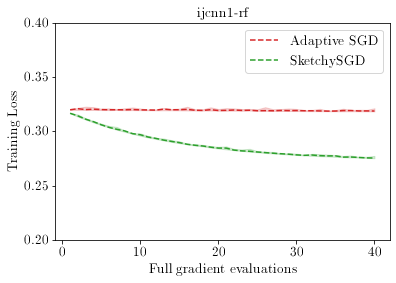

In [31]:
fig = plt.figure()
axes = plt.gca()
axes.set_title('ijcnn1-rf', fontsize=14)
axes.set_ylim([2e-1, 4e-1])
axes.tick_params(axis='both', which='major', labelsize=14)
axes.tick_params(axis='both', which='minor', labelsize=10)
axes.set_xlabel('Full gradient evaluations', fontsize=14)
axes.set_ylabel('Training Loss', fontsize=14)
plot_opt_curve(median_results, ql_results, qu_results, 'adasgd', 'auto', xaxes[0], 'train_loss', 'tab:red',
                    'dashed', None,'Adaptive SGD',axes)
plot_opt_curve(median_results, ql_results, qu_results, ('sketchysgd','nystrom'), 'auto', xaxes[0], 'train_loss', 'tab:green',
                    'dashed', None, 'SketchySGD', axes)
plt.legend(fontsize = 14)
save('lr_ablation_ijcnn1-rf',fig)

In [34]:
median_results, ql_results, qu_results = get_median_qu_ql_results(results_dir, 'e2006', opts, 10)

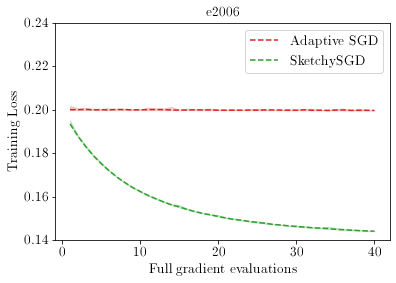

In [35]:
fig = plt.figure()
axes = plt.gca()
axes.set_title('e2006', fontsize=14)
axes.set_ylim([1.4e-1, 2.4e-1])
axes.tick_params(axis='both', which='major', labelsize=14)
axes.tick_params(axis='both', which='minor', labelsize=10)
axes.set_xlabel('Full gradient evaluations', fontsize=14)
axes.set_ylabel('Training Loss', fontsize=14)
plot_opt_curve(median_results, ql_results, qu_results, 'adasgd', 'auto', xaxes[0], 'train_loss', 'tab:red',
                    'dashed', None,'Adaptive SGD',axes)
plot_opt_curve(median_results, ql_results, qu_results, ('sketchysgd','nystrom'), 'auto', xaxes[0], 'train_loss', 'tab:green',
                    'dashed', None, 'SketchySGD', axes)
plt.legend(fontsize = 14)
save('lr_ablation_e2006',fig)
